,label,height,weight
0,1,188,71
1,2,161,68
2,0,178,52
3,2,136,63
4,1,145,52
...,...,...,...
19995,0,163,48
19996,2,139,70
19997,1,150,48
19998,1,189,69


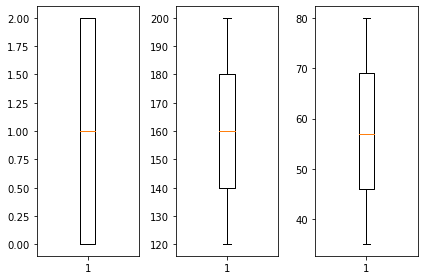

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split # train data와 test data를 쉽게 분리가능
from sklearn.model_selection import KFold # Cross Validation 용도


# 3. (03/08) BMI 데이터를 이용해서 모델 구현과 평가를 진행
# => 데이터 전처리 
# => 모델 구현
# => K-Fold Cross Validation을 이용해서 모델 검증(sklearn이용)
# => 우리모델의 최종 정확도를 출력!

df = pd.read_csv('./data/bmi.csv', skiprows=3)
display(df)

# 결측치 확인
df.isnull().sum() # 결측치 없음

# 이상치 확인
fig = plt.figure()

fig_1 = fig.add_subplot(1,3,1)
fig_2 = fig.add_subplot(1,3,2)
fig_3 = fig.add_subplot(1,3,3)

fig_1.boxplot(df['label'])
fig_2.boxplot(df['height'])
fig_3.boxplot(df['weight'])

fig.tight_layout()
plt.show() # 이상치 없음



In [15]:
# training data set
x_data_train, x_data_test, t_data_train, t_data_test = \
train_test_split(df[['height', 'weight']], df['label'], test_size=0.3, 
                 random_state=0)

# x_data의 정규화
scaler_x = MinMaxScaler()
scaler_x.fit(x_data_train)
x_data_train_norm = scaler_x.transform(x_data_train)
x_data_test_norm = scaler_x.transform(x_data_test)


# t data의 One-Hot Encoding
sess = tf.Session()
t_data_train_onehot = sess.run(tf.one_hot(t_data_train, depth=3))
t_data_test_onehot = sess.run(tf.one_hot(t_data_test, depth=3))

# 혼동을 줄이기 위해 변수 삭제
del t_data_train
del t_data_test

# tensorflow 구현
# placeholder
X = tf.placeholder(shape=[None,2], dtype=tf.float32)
T = tf.placeholder(shape=[None,3], dtype=tf.float32)

# Weight & bias
W = tf.Variable(tf.random.normal([2,3]), name='weight')
b = tf.Variable(tf.random.normal([3]), name='bias')

# Hypothesis
logit = tf.matmul(X,W) + b
H = tf.nn.softmax(logit) # softmax activation function

# loss function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit,
                                                                 labels=T))

# train 
train = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)

# parameter
num_of_epoch = 1000
batch_size = 100 # 한번에 읽어들일 학습할 데이터의 사이즈

# 학습용 함수
def run_train(sess, train_x, train_t):
    print('### 학습 시작')
    # 초기화
    sess.run(tf.global_variables_initializer())
    
    for step in range(num_of_epoch):
        total_batch = int(train_x.shape[0] / batch_size)
        
        for i in range(total_batch):
            batch_x = train_x[i*batch_size:(i+1)*batch_size]
            batch_t = train_t[i*batch_size:(i+1)*batch_size]
            _, loss_val = sess.run([train,loss], feed_dict={X:batch_x,
                                                            T:batch_t})
        if step % 100 == 0:
            print('Loss: {}'.format(loss_val))
    print('###학습 종료###')

predict = tf.argmax(H,1) # axis 열방향으로 비교 1
correct = tf.equal(predict, tf.argmax(T,1))
accuracy = tf.reduce_mean(tf.cast(correct, dtype=tf.float32))

# 학습하기
run_train(sess, x_data_train_norm, t_data_train_onehot)
    
# K-Fold Cross Validation
cv = 5
results = []
kf = KFold(n_splits=cv, shuffle=True)

for training_idx, validation_idx in kf.split(x_data_train_norm):
  
    training_x = x_data_train_norm[training_idx] 
    training_t = t_data_train_onehot[training_idx]
    
    val_x = x_data_train_norm[validation_idx]
    val_t = t_data_train_onehot[validation_idx]
    
    # 학습
    run_train(sess,training_x,training_t)
    results.append(sess.run(accuracy, feed_dict={X:val_x, T:val_t})) 
    
print('측정한 각각의 결과값 : {}'.format(results))
print('최종 K-Fold 교차검증을 사용한 Accuracy : {}'.format(np.mean(results)))

### 학습 시작
Loss: 0.7693548798561096
Loss: 0.20501376688480377
Loss: 0.1622217297554016
Loss: 0.14267855882644653
Loss: 0.13093744218349457
Loss: 0.12289657443761826
Loss: 0.11694422364234924
Loss: 0.11230472475290298
Loss: 0.10855316370725632
Loss: 0.10543422400951385
###학습 종료###
### 학습 시작
Loss: 0.987144947052002
Loss: 0.19155113399028778
Loss: 0.1453828364610672
Loss: 0.12426915019750595
Loss: 0.11156917363405228
Loss: 0.10286101698875427
Loss: 0.09640760719776154
Loss: 0.09137041121721268
Loss: 0.08729320764541626
Loss: 0.08389909565448761
###학습 종료###
### 학습 시작
Loss: 1.0290501117706299
Loss: 0.22201865911483765
Loss: 0.1732105314731598
Loss: 0.1506696194410324
Loss: 0.1370757520198822
Loss: 0.12776346504688263
Loss: 0.12087960541248322
Loss: 0.11552540957927704
Loss: 0.11120676249265671
Loss: 0.10762657970190048
###학습 종료###
### 학습 시작
Loss: 0.9281492829322815
Loss: 0.20745842158794403
Loss: 0.16190952062606812
Loss: 0.14109371602535248
Loss: 0.12864772975444794
Loss: 0.1201883032917976

In [16]:
# Testing
run_train(sess,training_x,training_t)
final_accuracy = sess.run(accuracy, feed_dict={X:x_data_test_norm,
                                               T:t_data_test_onehot})
print('우리 Model의 최종 정확도는 : {}'.format(final_accuracy))


### 학습 시작
Loss: 0.880439817905426
Loss: 0.2093416154384613
Loss: 0.16143715381622314
Loss: 0.139430433511734
Loss: 0.12620940804481506
Loss: 0.11718261986970901
Loss: 0.11053065210580826
Loss: 0.10537474602460861
Loss: 0.10122837126255035
Loss: 0.09780324995517731
###학습 종료###
우리 Model의 최종 정확도는 : 0.9829999804496765
